### **<u> Preliminary Cells </u>**

In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc

vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("e_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("e_data/data'+number+'.csv")'
        exec(new_string)
        df = 'df'+number
        new_df = locals()[df]
        df_list.append(new_df)
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(item)
            
band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2,.05])
    return my_fit[1]

In [2]:
spec_list = []
for number in new_array:
    my_string = 'spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

time_list_i = []
for number in new_array:
    my_string = 'ettime'+number+' = df'+number+"['ettime']"
    exec(my_string)
    time = 'ettime'+number
    time_list_i.append(locals()[time])

time_list_f = []
for df in time_list_i:
    for time in df:
        time_list_f.append(time)

total_spectrum = []
for spec in spec_list:
    for spectrum in spec:
        total_spectrum.append(spectrum)

total_spectrum = np.asarray(total_spectrum)
total_spectrum_2 = dc(total_spectrum)
print('List 1: '+str(np.shape(total_spectrum)))
print('List 2 (Copy): '+str(np.shape(total_spectrum_2))) # Confirms that DeepCopy works correctly

List 1: (12655, 256)
List 2 (Copy): (12655, 256)


###  **Prior to first median filter**

In [3]:
bad_indices = []
for index,spectrum in enumerate(total_spectrum_2):
    peaks, _ = find_peaks(np.abs(spectrum[158:257]),height=.04)
    peaks = peaks+158
    if len(peaks) > 0:
        bad_indices.append(index)

print(np.shape(bad_indices))

(3377,)


In [5]:
bad_spectra = total_spectrum_2[bad_indices]
good_spectra = []
for index,spectrum in enumerate(total_spectrum):
    if index not in bad_indices:
        good_spectra.append(spectrum)

bad_spectra = np.asarray(bad_spectra)
good_spectra = np.asarray(good_spectra)

print(np.shape(bad_spectra))
print(np.shape(good_spectra))

(3377, 256)
(9278, 256)


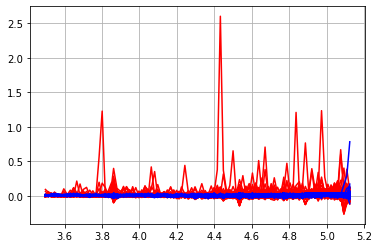

In [6]:
%matplotlib inline
plt.figure(facecolor='white')
for spectrum in bad_spectra:
    plt.plot(vims_wave[158:256],spectrum[158:256],color='red')
for spectrum in good_spectra:
    plt.plot(vims_wave[158:256],spectrum[158:256],color='blue')
plt.grid()
plt.show()

In [7]:
for (i,j) in zip(range(0,256),range(1,257)):
    median = np.median(total_spectrum[:,i:j])
    vals = total_spectrum_2[:,i:j]
    std = np.std(total_spectrum[:,i:j])
    ind = np.where(np.abs(vals-median)>3*std) # 3 STD as benchmark
    vals[ind] = median

In [8]:
for index,wavelength in enumerate(vims_wave[160:180]):
    print(index+160,wavelength)

160 3.53015
161 3.54664
162 3.56274
163 3.58034
164 3.5961
165 3.61387
166 3.63085
167 3.64853
168 3.66522
169 3.68283
170 3.69953
171 3.71743
172 3.73439
173 3.75103
174 3.76763
175 3.78444
176 3.80083
177 3.81742
178 3.83472
179 3.85141


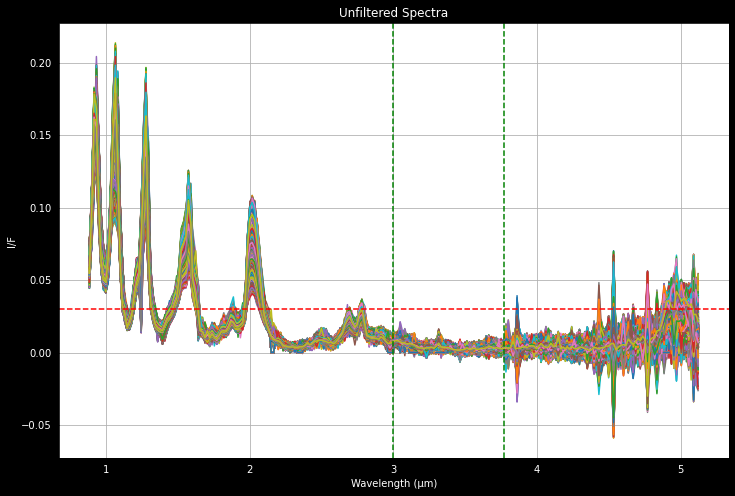

In [9]:
%matplotlib inline
plt.figure(facecolor='black',figsize=(12,8))
plt.title('Unfiltered Spectra',color='white')
for spectrum in total_spectrum_2[::3]:
    plt.plot(vims_wave,spectrum)
plt.axhline(y=.03,color='r',linestyle='--')
plt.axvline(x=vims_wave[128],color='g',linestyle='--')
plt.axvline(x=vims_wave[174],color='g',linestyle='--')
plt.xticks(color='white')
plt.xlabel('Wavelength (µm)',color='white')
# plt.xlim([vims_wave[160],vims_wave[185]])
plt.yticks(color='white')
plt.ylabel('I/F',color='white')
plt.grid()
plt.show()

### Objective: Filter spectra that are ONLY included in bad_spectra indices list

In [66]:
bad_indices = []
for index,spectrum in enumerate(total_spectrum_2):
    peaks, _ = find_peaks(np.abs(spectrum[158:257]),height=.04)
    peaks = peaks+158
    if len(peaks) > 0:
        bad_indices.append(index)

print(np.shape(bad_indices))

(2466,)


In [67]:
bad_spectra = total_spectrum_2[bad_indices]
good_spectra = []
for index,spectrum in enumerate(total_spectrum_2):
    if index not in bad_indices:
        good_spectra.append(spectrum)

bad_spectra = np.asarray(bad_spectra)
good_spectra = np.asarray(good_spectra)

print(np.shape(bad_spectra))
print(np.shape(good_spectra))

(2466, 256)
(10189, 256)


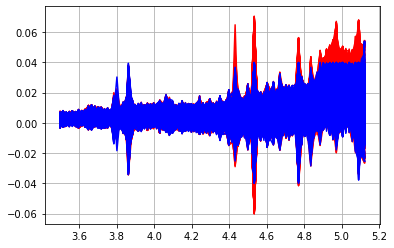

In [68]:
%matplotlib inline
plt.figure(facecolor='white')
for spectrum in bad_spectra:
    plt.plot(vims_wave[158:256],spectrum[158:256],color='red')
for spectrum in good_spectra:
    plt.plot(vims_wave[158:256],spectrum[158:256],color='blue')
plt.grid()
plt.show()

In [65]:
for (i,j) in zip(range(235,256),range(236,257)):
    median = np.median(total_spectrum_2[:,i:j])
    if np.abs(.04-median) < .019:
        print((median,i,j))

(0.0210503, 243, 244)
(0.0217651, 244, 245)
(0.021346, 245, 246)
(0.022093, 246, 247)
(0.0212515, 247, 248)
